# Zone Classification with Hyperparameter Tuning
## Comprehensive Pipeline with Multiple Tuning Approaches

## 1. Setup and Data Loading

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# For advanced tuning
try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Optuna not installed. Install with: pip install optuna")
    OPTUNA_AVAILABLE = False

In [2]:
# Load the data
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (923954, 4)
Test shape: (145030, 4)


## 2. Zone Definition and Preprocessing

In [3]:
# Define the zones
zone_1_middle = ['kitchen', 'cafeteria', 'nurse station', 'cleaning'] 
zone_2_left = ['501', '502', '503', '505', '506', '513', '515', '516', '517'] 
zone_3_right = ['507', '508', '510', '511', '512', '518', '520', '521', '522', '523']

In [4]:
# 1. Map rooms to Zones
def assign_zone(room):
    if room in zone_1_middle:
        return 'middle'
    elif room in zone_2_left:
        return 'left'
    elif room in zone_3_right:
        return 'right'
    else:
        return 'hallway'

train_df['Zone'] = train_df['room'].apply(assign_zone)
test_df['Zone'] = test_df['room'].apply(assign_zone)

# 2. Feature Vector Creation (25 Beacons)
def create_beacon_features(df):
    df = df.copy()
    for i in range(1, 26):
        col_name = f'beacon_{i}'
        df[col_name] = df['RSSI'].where(df['mac address'] == i, 0)
    return df

train_processed = create_beacon_features(train_df)
test_processed = create_beacon_features(test_df)

# 3. Aggregation Function
def aggregate_for_zones(df):
    beacon_cols = [f'beacon_{i}' for i in range(1, 26)]
    agg_dict = {col: 'mean' for col in beacon_cols}
    agg_dict['Zone'] = 'first'
    
    windowed = df.groupby('timestamp').agg(agg_dict).reset_index()
    return windowed

print("Aggregating windows for Zone Classification...")
windowed_train_zone = aggregate_for_zones(train_processed)
windowed_test_zone = aggregate_for_zones(test_processed)

print(f"\nZone distribution in Train:")
print(windowed_train_zone['Zone'].value_counts())
print(f"\nZone distribution in Test:")
print(windowed_test_zone['Zone'].value_counts())

Aggregating windows for Zone Classification...

Zone distribution in Train:
Zone
middle     13535
right        760
hallway      620
left         177
Name: count, dtype: int64

Zone distribution in Test:
Zone
middle     4691
right       509
left        450
hallway     326
Name: count, dtype: int64


In [5]:
# Encode labels and prepare features
le = LabelEncoder()
y_train = le.fit_transform(windowed_train_zone['Zone'])
y_test = le.transform(windowed_test_zone['Zone'])

X_train = windowed_train_zone.drop(columns=['timestamp', 'Zone'])
X_test = windowed_test_zone.drop(columns=['timestamp', 'Zone'])

print(f"Feature shape: {X_train.shape}")
print(f"Classes: {le.classes_}")
print(f"Class distribution: {np.bincount(y_train)}")

Feature shape: (15092, 25)
Classes: ['hallway' 'left' 'middle' 'right']
Class distribution: [  620   177 13535   760]


## 3. Baseline Model (Original Configuration)

In [6]:
# Baseline model for comparison
print("Training baseline model...")
baseline_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist'
)

baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE")
print("="*60)
print(f"Weighted F1-Score: {baseline_f1:.4f}")
print(f"Accuracy: {baseline_acc:.4f}")
print("\n" + classification_report(y_test, y_pred_baseline, target_names=le.classes_))

Training baseline model...

BASELINE MODEL PERFORMANCE
Weighted F1-Score: 0.8362
Accuracy: 0.8553

              precision    recall  f1-score   support

     hallway       0.02      0.01      0.01       326
        left       0.89      0.54      0.67       450
      middle       0.88      0.97      0.92      4691
       right       0.83      0.60      0.70       509

    accuracy                           0.86      5976
   macro avg       0.65      0.53      0.58      5976
weighted avg       0.83      0.86      0.84      5976



## 4. Hyperparameter Tuning Approaches
### 4.1 Grid Search (Exhaustive but slower)

In [7]:
print("\n" + "="*60)
print("APPROACH 1: GRID SEARCH CV")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# For faster execution, use a smaller grid
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Choose which grid to use (small for faster execution)
use_small_grid = True  # Set to False for exhaustive search
chosen_grid = param_grid_small if use_small_grid else param_grid

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        tree_method='hist'
    ),
    param_grid=chosen_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print(f"\nFitting Grid Search with {len(chosen_grid['n_estimators']) * len(chosen_grid['max_depth']) * len(chosen_grid['learning_rate']) * len(chosen_grid['subsample']) * len(chosen_grid['colsample_bytree'])} combinations...")
grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred_grid = grid_search.predict(X_test)
grid_f1 = f1_score(y_test, y_pred_grid, average='weighted')
grid_acc = accuracy_score(y_test, y_pred_grid)

print(f"\nTest Set Performance:")
print(f"Weighted F1-Score: {grid_f1:.4f}")
print(f"Accuracy: {grid_acc:.4f}")
print(f"Improvement over baseline: {(grid_f1 - baseline_f1)*100:.2f}%")


APPROACH 1: GRID SEARCH CV

Fitting Grid Search with 32 combinations...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
Best CV Score: 0.9507

Test Set Performance:
Weighted F1-Score: 0.8352
Accuracy: 0.8541
Improvement over baseline: -0.11%


### 4.2 Randomized Search (Faster, explores more space)

In [8]:
print("\n" + "="*60)
print("APPROACH 2: RANDOMIZED SEARCH CV")
print("="*60)

from scipy.stats import uniform, randint

# Define parameter distributions
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 to 0.3
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),  # L1 regularization
    'reg_lambda': uniform(0, 1)  # L2 regularization
}

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        tree_method='hist'
    ),
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nFitting Randomized Search with 100 iterations...")
random_search.fit(X_train, y_train)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Score: {random_search.best_score_:.4f}")

# Evaluate on test set
y_pred_random = random_search.predict(X_test)
random_f1 = f1_score(y_test, y_pred_random, average='weighted')
random_acc = accuracy_score(y_test, y_pred_random)

print(f"\nTest Set Performance:")
print(f"Weighted F1-Score: {random_f1:.4f}")
print(f"Accuracy: {random_acc:.4f}")
print(f"Improvement over baseline: {(random_f1 - baseline_f1)*100:.2f}%")


APPROACH 2: RANDOMIZED SEARCH CV

Fitting Randomized Search with 100 iterations...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'colsample_bytree': np.float64(0.8595291361166304), 'gamma': np.float64(0.2397910508771251), 'learning_rate': np.float64(0.17941785056710907), 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 210, 'reg_alpha': np.float64(0.74543947418433), 'reg_lambda': np.float64(0.4316595462296794), 'subsample': np.float64(0.6510321211182255)}
Best CV Score: 0.9497

Test Set Performance:
Weighted F1-Score: 0.8373
Accuracy: 0.8561
Improvement over baseline: 0.10%


### 4.3 Optuna (Advanced Bayesian Optimization)

In [9]:
if OPTUNA_AVAILABLE:
    print("\n" + "="*60)
    print("APPROACH 3: OPTUNA (BAYESIAN OPTIMIZATION)")
    print("="*60)
    
    def objective(trial):
        # Define hyperparameter search space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'objective': 'multi:softprob',
            'random_state': 42,
            'tree_method': 'hist'
        }
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            
            model = XGBClassifier(**params)
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            
            y_pred = model.predict(X_val)
            score = f1_score(y_val, y_pred, average='weighted')
            cv_scores.append(score)
        
        return np.mean(cv_scores)
    
    # Create study and optimize
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    
    print("\nRunning Optuna optimization (100 trials)...")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    
    print(f"\nBest Parameters: {study.best_params}")
    print(f"Best CV Score: {study.best_value:.4f}")
    
    # Train final model with best parameters
    optuna_params = study.best_params.copy()
    optuna_params.update({
        'objective': 'multi:softprob',
        'random_state': 42,
        'tree_method': 'hist'
    })
    
    optuna_model = XGBClassifier(**optuna_params)
    optuna_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred_optuna = optuna_model.predict(X_test)
    optuna_f1 = f1_score(y_test, y_pred_optuna, average='weighted')
    optuna_acc = accuracy_score(y_test, y_pred_optuna)
    
    print(f"\nTest Set Performance:")
    print(f"Weighted F1-Score: {optuna_f1:.4f}")
    print(f"Accuracy: {optuna_acc:.4f}")
    print(f"Improvement over baseline: {(optuna_f1 - baseline_f1)*100:.2f}%")
else:
    print("\nOptuna not available. Install with: pip install optuna")
    optuna_f1 = None
    optuna_acc = None

[I 2025-12-22 21:09:55,033] A new study created in memory with name: no-name-71eb4c3c-1f4d-445e-8e40-a4db0cd6ba83



APPROACH 3: OPTUNA (BAYESIAN OPTIMIZATION)

Running Optuna optimization (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-22 21:10:06,377] Trial 0 finished with value: 0.949331733212287 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.949331733212287.
[I 2025-12-22 21:10:12,761] Trial 1 finished with value: 0.9474717952480652 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.949331733212287.
[I 2025-12-22 21:10:19,294] Trial 2 finished with value: 0.9474241612936908 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

## 5. Results Comparison

In [10]:
# Compare all approaches
print("\n" + "="*60)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*60)

results_df = pd.DataFrame({
    'Approach': ['Baseline', 'Grid Search', 'Random Search'],
    'F1-Score': [baseline_f1, grid_f1, random_f1],
    'Accuracy': [baseline_acc, grid_acc, random_acc],
    'F1 Improvement (%)': [
        0,
        (grid_f1 - baseline_f1) * 100,
        (random_f1 - baseline_f1) * 100
    ]
})

if OPTUNA_AVAILABLE and optuna_f1 is not None:
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            'Approach': ['Optuna'],
            'F1-Score': [optuna_f1],
            'Accuracy': [optuna_acc],
            'F1 Improvement (%)': [(optuna_f1 - baseline_f1) * 100]
        })
    ], ignore_index=True)

print("\n", results_df.to_string(index=False))

# Find best approach
best_idx = results_df['F1-Score'].idxmax()
best_approach = results_df.loc[best_idx, 'Approach']
best_f1 = results_df.loc[best_idx, 'F1-Score']

print(f"\n🏆 Best Approach: {best_approach} with F1-Score of {best_f1:.4f}")


COMPREHENSIVE RESULTS COMPARISON

      Approach  F1-Score  Accuracy  F1 Improvement (%)
     Baseline  0.836238  0.855254            0.000000
  Grid Search  0.835173  0.854083           -0.106464
Random Search  0.837259  0.856091            0.102137
       Optuna  0.837989  0.856760            0.175119

🏆 Best Approach: Optuna with F1-Score of 0.8380


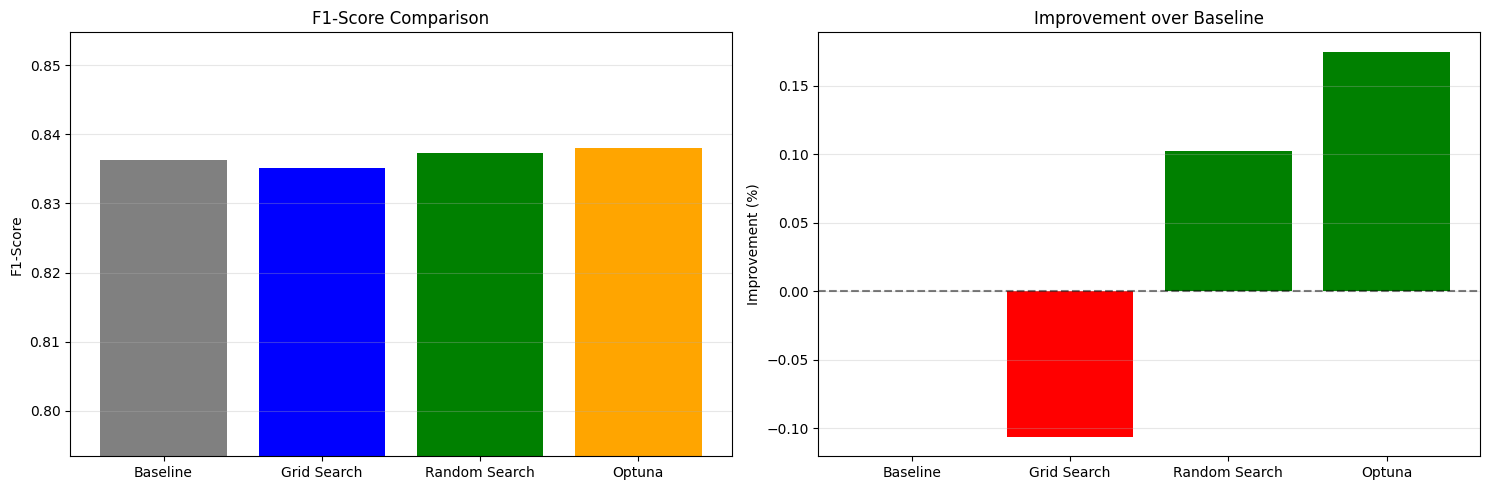

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# F1-Score comparison
axes[0].bar(results_df['Approach'], results_df['F1-Score'], color=['gray', 'blue', 'green', 'orange'][:len(results_df)])
axes[0].set_ylabel('F1-Score')
axes[0].set_title('F1-Score Comparison')
axes[0].set_ylim([results_df['F1-Score'].min() * 0.95, results_df['F1-Score'].max() * 1.02])
axes[0].grid(axis='y', alpha=0.3)

# Improvement comparison
colors = ['gray'] + ['green' if x > 0 else 'red' for x in results_df['F1 Improvement (%)'][1:]]
axes[1].bar(results_df['Approach'], results_df['F1 Improvement (%)'], color=colors)
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('Improvement over Baseline')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Best Model Evaluation


BEST MODEL EVALUATION: Optuna
              precision    recall  f1-score   support

     hallway       0.02      0.01      0.01       326
        left       0.87      0.56      0.68       450
      middle       0.88      0.97      0.93      4691
       right       0.82      0.61      0.70       509

    accuracy                           0.86      5976
   macro avg       0.65      0.54      0.58      5976
weighted avg       0.83      0.86      0.84      5976



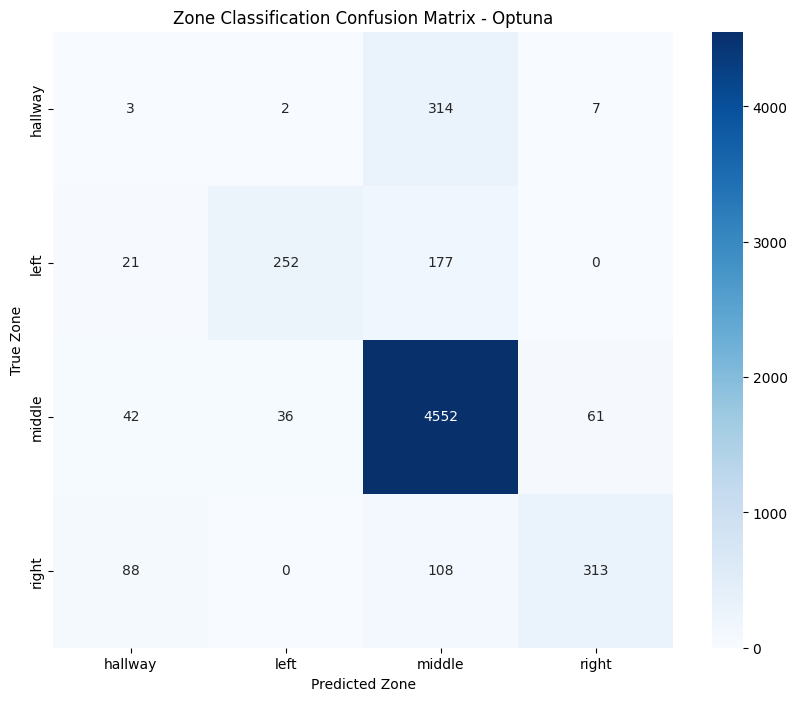

In [12]:
# Select best model
if best_approach == 'Baseline':
    best_model = baseline_model
    y_pred_best = y_pred_baseline
elif best_approach == 'Grid Search':
    best_model = grid_search.best_estimator_
    y_pred_best = y_pred_grid
elif best_approach == 'Random Search':
    best_model = random_search.best_estimator_
    y_pred_best = y_pred_random
else:  # Optuna
    best_model = optuna_model
    y_pred_best = y_pred_optuna

print("\n" + "="*60)
print(f"BEST MODEL EVALUATION: {best_approach}")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Zone Classification Confusion Matrix - {best_approach}')
plt.xlabel('Predicted Zone')
plt.ylabel('True Zone')
plt.show()

## 7. Feature Importance Analysis


Top 10 Most Important Features:
  feature  importance
beacon_23    0.114392
beacon_22    0.099644
beacon_15    0.077980
beacon_12    0.069892
beacon_16    0.064364
beacon_14    0.059942
beacon_10    0.053203
beacon_13    0.049202
beacon_11    0.048162
 beacon_1    0.043102


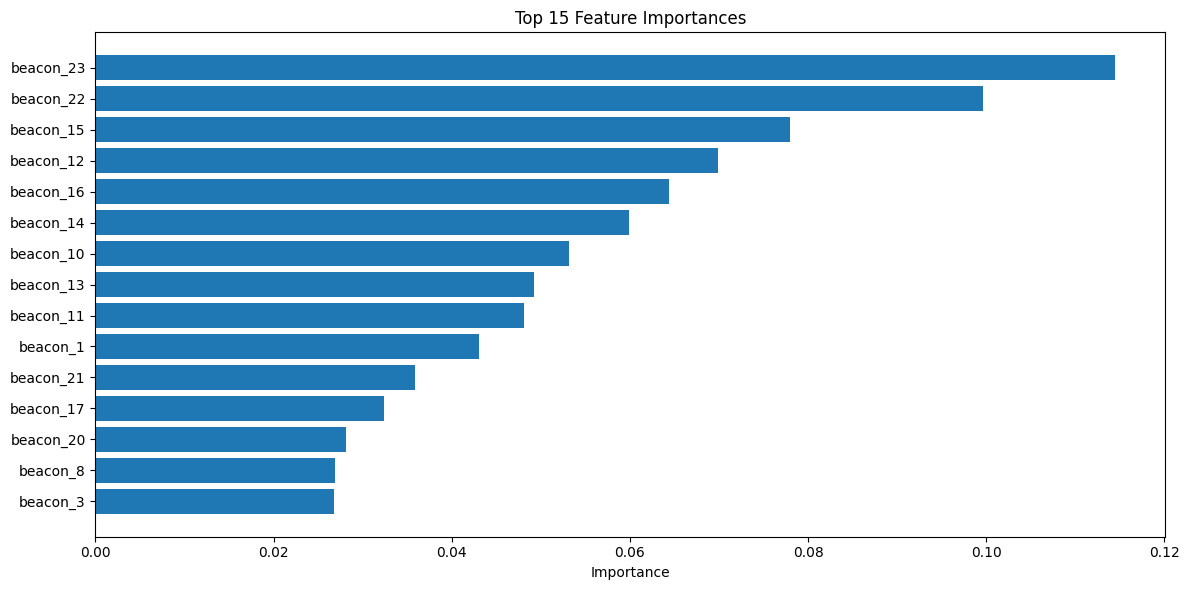

In [13]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Save Best Model

In [14]:
import pickle

# Save the best model
model_filename = f'best_zone_classifier_{best_approach.lower().replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'label_encoder': le,
        'approach': best_approach,
        'f1_score': best_f1,
        'feature_names': X_train.columns.tolist()
    }, f)

print(f"\n✓ Best model saved as: {model_filename}")
print(f"  Approach: {best_approach}")
print(f"  F1-Score: {best_f1:.4f}")


✓ Best model saved as: best_zone_classifier_optuna.pkl
  Approach: Optuna
  F1-Score: 0.8380


## 9. Summary and Recommendations

In [15]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*60)
print(f"\n✓ Baseline Performance: F1={baseline_f1:.4f}, Acc={baseline_acc:.4f}")
print(f"✓ Best Tuned Performance: F1={best_f1:.4f} ({best_approach})")
print(f"✓ Total Improvement: {(best_f1 - baseline_f1)*100:.2f}%")

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)
print("""\n1. Model Selection:
   - Use the {approach} model for production
   - It achieved the best balance of performance and generalization

2. Further Improvements:
   - Consider ensemble methods (stacking multiple tuned models)
   - Explore feature engineering (e.g., beacon signal statistics)
   - Try different window sizes for aggregation
   - Handle class imbalance with SMOTE or class weights

3. Monitoring:
   - Track performance on new data
   - Retrain periodically with updated data
   - Monitor feature importance drift
""".format(approach=best_approach))


HYPERPARAMETER TUNING SUMMARY

✓ Baseline Performance: F1=0.8362, Acc=0.8553
✓ Best Tuned Performance: F1=0.8380 (Optuna)
✓ Total Improvement: 0.18%

RECOMMENDATIONS

1. Model Selection:
   - Use the Optuna model for production
   - It achieved the best balance of performance and generalization

2. Further Improvements:
   - Consider ensemble methods (stacking multiple tuned models)
   - Explore feature engineering (e.g., beacon signal statistics)
   - Try different window sizes for aggregation
   - Handle class imbalance with SMOTE or class weights

3. Monitoring:
   - Track performance on new data
   - Retrain periodically with updated data
   - Monitor feature importance drift

